In [30]:
import pandas as pd
import os

parent_dir = os.path.dirname(os.getcwd())
df = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/imdb_2.csv')
# train = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/train70_clf.csv')
# test = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/test30_clf.csv')

In [31]:
titletype_cols = [
    'movie', 'short', 'tvEpisode',
    'tvSeries', 'tvSpecial', 'video',
]

In [32]:
df = df.loc[df['videoGame'] == 0]

df['movie'] = (df['movie'] | (df['tvMovie'])).astype(int)
df['short'] = (df['short'] | (df['tvShort'])).astype(int)
df['tvSeries'] = (df['tvSeries'] | (df['tvMiniSeries'])).astype(int)
df.drop(columns=['tvMiniSeries', 'tvMovie', 'tvShort'], inplace=True)

df.columns

Index(['startYear', 'runtimeMinutes', 'totalCredits', 'canHaveEpisodes',
       'numRegions', 'ratingCount', 'castNumber', 'companiesNumber',
       'averageRating', 'writerCredits', 'directorsCredits',
       'totalNominations', 'totalMedia', 'totalReviews', 'Asia', 'Africa',
       'Europe', 'North America', 'South America', 'Australia',
       'Continent Unknown', 'genre1', 'genre2', 'genre3', 'movie', 'short',
       'tvEpisode', 'tvSeries', 'tvSpecial', 'video', 'videoGame'],
      dtype='object')

In [ ]:
# Train-test-val split
from turtle import title
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[titletype_cols])
train, val = train_test_split(train, test_size=0.25, random_state=42, stratify=train[titletype_cols])

X_train = train.drop(columns=titletype_cols + ['canHaveEpisodes'])
y_train = train[titletype_cols]

X_val = val.drop(columns=titletype_cols + ['canHaveEpisodes'])
y_val = val[titletype_cols]

X_test = test.drop(columns=titletype_cols + ['canHaveEpisodes'])
y_test = test[titletype_cols]

In [34]:
# Feature selection
numerical_cols = [
    'startYear', 'runtimeMinutes', 'totalCredits',
    'numRegions', 'ratingCount', 'castNumber',
    'companiesNumber', 'writerCredits', 'directorsCredits',
    'totalNominations', 'totalMedia', 'totalReviews',
    'averageRating'
]

region_cols = [
    'Asia', 'Africa', 'Europe',
    'North America', 'South America', 'Australia',
    'Continent Unknown'
]

genre_cols = ['genre1', 'genre2', 'genre3']

selected_features = numerical_cols + region_cols + genre_cols

# selected_features / titletype_cols
to_scale = [feat for feat in selected_features if feat not in titletype_cols]

genre_cols = ['genre1', 'genre2', 'genre3']

X_train = X_train[selected_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

In [35]:
from re import X
import numpy as np

to_log = [
       'numRegions', 'ratingCount', 'companiesNumber',
       'totalNominations', 'totalMedia', 'totalReviews',
       # 'deltaCredits'
]

# Apply log transformation safely (fill NaN, clip negatives)
for col in to_log:
    X_train[col] = np.log1p(X_train[col].fillna(0).clip(lower=0))
    X_val[col] = np.log1p(X_val[col].fillna(0).clip(lower=0))
    X_test[col] = np.log1p(X_test[col].fillna(0).clip(lower=0))

In [36]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_val[to_scale] = scaler.transform(X_val[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

In [37]:
# from sklearn.preprocessing import LabelEncoder

# # One-hot encode y_train for categorical_crossentropy
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)

In [38]:
# Prepare input
X_train = {
    'numerical': X_train[numerical_cols].values,
    'region': X_train[region_cols].values,
    'genre': X_train[genre_cols].values
}

X_val = {
    'numerical': X_val[numerical_cols].values,
    'region': X_val[region_cols].values,
    'genre': X_val[genre_cols].values
}

X_test = {
    'numerical': X_test[numerical_cols].values,
    'region': X_test[region_cols].values,
    'genre': X_test[genre_cols].values
}

In [39]:
y_train

,movie,short,tvEpisode,tvSeries,tvSpecial,video
53825,0,0,1,0,0,0
139300,0,0,1,0,0,0
21264,1,0,0,0,0,0
59641,0,0,1,0,0,0
53918,0,0,1,0,0,0
...,...,...,...,...,...,...
105356,0,0,1,0,0,0
91895,0,0,1,0,0,0
119134,1,0,0,0,0,0
108268,0,0,1,0,0,0


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf

# Simple neural network model
# model = Sequential([
#     Input(shape=(X_train.shape[1],)),
#     Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(64, activation='relu'),
#     # Dropout(0.2),
#     Dense(32, activation='relu'),
#     Dropout(0.3),
#     Dense(16, activation='relu'),
#     Dense(len(le.classes_), activation='softmax')
# ])

# Numerical input
numerical_input = layers.Input(shape=(len(numerical_cols),), name='numerical')

# region branch
region_input = layers.Input(shape=(len(region_cols),), name='region')

region_branch = layers.Dense(8, use_bias=False)(region_input)
region_branch = layers.BatchNormalization()(region_branch)
region_branch = layers.Activation('relu')(region_branch)

# genre branch
genre_input = layers.Input(shape=(len(genre_cols),), name='genre')
genre_branch = layers.Dense(8, use_bias=False)(genre_input)
genre_branch = layers.BatchNormalization()(genre_branch)
genre_branch = layers.Activation('relu')(genre_branch)


# Concatenate all branches
concatenated = layers.concatenate([numerical_input, region_branch, genre_branch])

# 1st layer
x = layers.Dense(64, use_bias=False)(concatenated)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)

# 2nd layer
x = layers.Dense(32, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.3)(x)


# Output layer
output = layers.Dense(len(titletype_cols), activation='softmax')(x)

model = tf.keras.Model(
    inputs=[numerical_input, region_input, genre_input],
    outputs=output
)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.summary()

In [41]:
from operator import call
from sklearn.utils.class_weight import compute_class_weight

# Class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(titletype_cols)),
    y=np.argmax(y_train.values, axis=1)
)
class_weights = {i: class_weights[i] for i in range(len(titletype_cols))}  # Convert to dict for Keras

history = model.fit(
    X_train, y_train,
    epochs=200, batch_size=64, validation_data=(X_val, y_val),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    class_weight=class_weights
)

Epoch 1/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5078 - loss: 1.3530 - val_accuracy: 0.8380 - val_loss: 0.5260
Epoch 2/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7845 - loss: 0.8065 - val_accuracy: 0.8518 - val_loss: 0.4555
Epoch 3/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8059 - loss: 0.7404 - val_accuracy: 0.8604 - val_loss: 0.4156
Epoch 4/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8151 - loss: 0.7173 - val_accuracy: 0.8608 - val_loss: 0.4073
Epoch 5/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8192 - loss: 0.6761 - val_accuracy: 0.8660 - val_loss: 0.4008
Epoch 6/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8211 - loss: 0.6768 - val_accuracy: 0.8810 - val_loss: 0.3528
Epoch 7/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8258 - loss: 0.6601 - val_accuracy: 0.8781 - val_loss: 0.3648
Epoch 8/200
1293/1293 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8262 - loss: 0

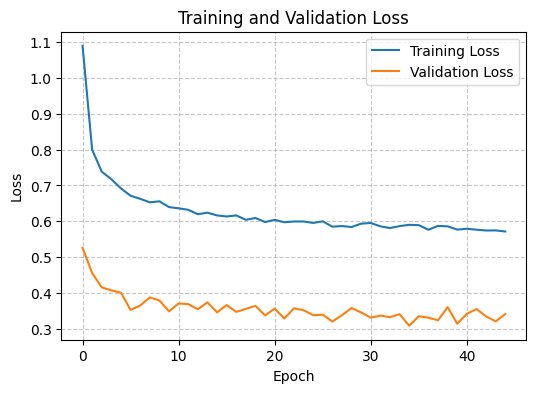

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

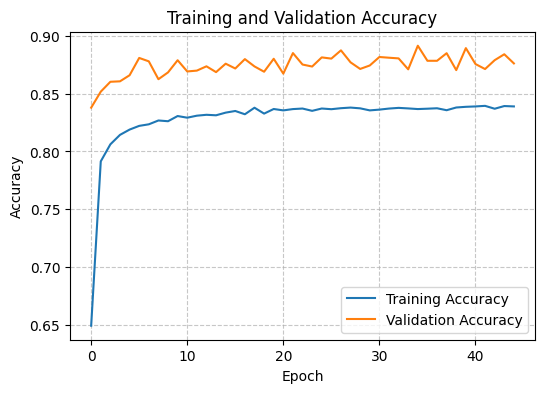

1386/1386 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step


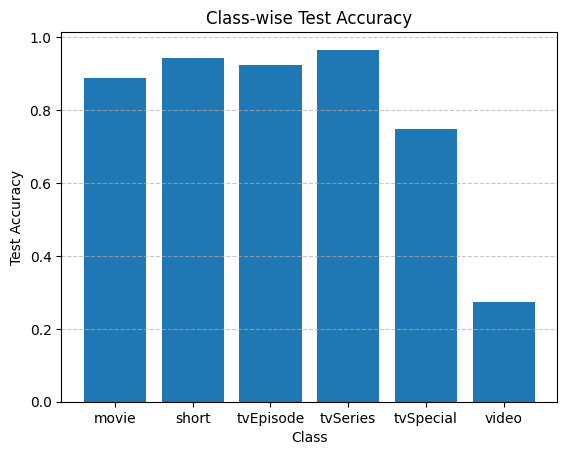

In [43]:
from sklearn.metrics import accuracy_score

# Plot overall accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

# Class-wise accuracy on test set

y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate accuracy for each class
class_accuracies = {}
for i, class_name in enumerate(titletype_cols):
    idx = (y_test.values.argmax(axis=1) == i)
    class_acc = accuracy_score(y_test.values.argmax(axis=1)[idx], y_pred_classes[idx])
    class_accuracies[class_name] = class_acc

# Plot class-wise accuracy
plt.bar(class_accuracies.keys(), class_accuracies.values())
plt.xlabel('Class')
plt.ylabel('Test Accuracy')
plt.title('Class-wise Test Accuracy')
# plt.xticks(rotation=45)
plt.grid(alpha=0.7, linestyle='--', axis='y')
plt.show()

1386/1386 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step
              precision    recall  f1-score   support

       movie       0.95      0.89      0.92     12947
       short       0.89      0.94      0.92      4994
   tvEpisode       0.98      0.92      0.95     21249
    tvSeries       0.79      0.97      0.87      3247
   tvSpecial       0.13      0.75      0.22       345
       video       0.49      0.27      0.35      1545

    accuracy                           0.90     44327
   macro avg       0.71      0.79      0.70     44327
weighted avg       0.92      0.90      0.91     44327



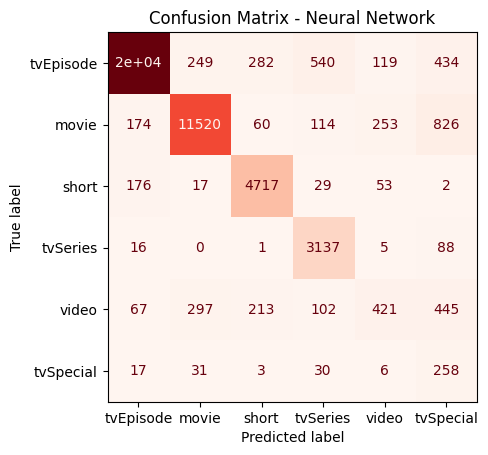

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix


# Predict on the test set
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.values.argmax(axis=1)

# Print classification report
print(classification_report(y_true, y_pred, target_names=titletype_cols))

report = classification_report(y_true, y_pred, target_names=titletype_cols, output_dict=True)
support = [report[label]['support'] for label in titletype_cols]
sorted_indices = sorted(range(len(support)), key=lambda k: support[k], reverse=True)
sorted_labels = [titletype_cols[i] for i in sorted_indices]

# 1. Manually create the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(len(titletype_cols)))

# 2. Sort the confusion matrix based on the sorted_indices
cm_sorted = cm[sorted_indices, :]  # Sort rows
cm_sorted = cm_sorted[:, sorted_indices] # Sort columns

# 3. Create a new ConfusionMatrixDisplay object with the sorted matrix and sorted labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sorted, display_labels=sorted_labels)
disp.xticks_rotation = 45

# 4. Plot the sorted confusion matrix
disp.plot(cmap='Reds', colorbar=False)

plt.title('Confusion Matrix - Neural Network')


plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

1386/1386 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step


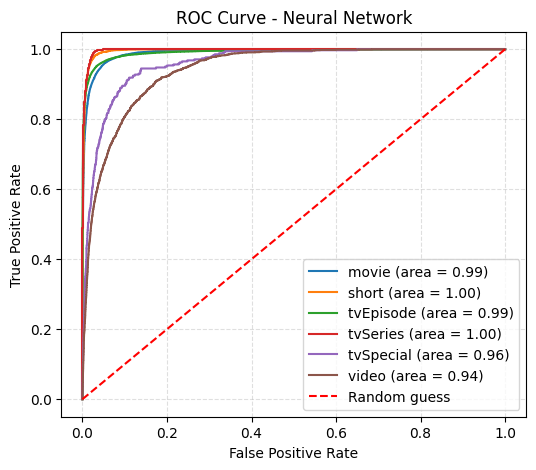

In [45]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
# Convert y_test to single-label array
y_true = y_test.values.argmax(axis=1)
y_score = model.predict(X_test)

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 5))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(titletype_cols[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

In [46]:
model.save('neural_net_titletype.keras')
y_train

,movie,short,tvEpisode,tvSeries,tvSpecial,video
53825,0,0,1,0,0,0
139300,0,0,1,0,0,0
21264,1,0,0,0,0,0
59641,0,0,1,0,0,0
53918,0,0,1,0,0,0
...,...,...,...,...,...,...
105356,0,0,1,0,0,0
91895,0,0,1,0,0,0
119134,1,0,0,0,0,0
108268,0,0,1,0,0,0


# Rating

In [132]:
import pandas as pd
import os

parent_dir = os.path.dirname(os.getcwd())
df = pd.read_csv(parent_dir + '/dm2_dataset_2425_imdb/imdb_2.csv')

In [133]:
numerical_cols = [
    'startYear', 'runtimeMinutes', 'totalCredits',
    'numRegions', 'ratingCount', 'castNumber',
    'companiesNumber', 'writerCredits', 'directorsCredits',
    'totalNominations', 'totalMedia', 'totalReviews',
]

titletype_cols = [
    'movie', 'short', 'tvEpisode',
    'tvSeries', 'tvSpecial', 'video',
]

region_cols = [
    'Asia', 'Africa', 'Europe',
    'North America', 'South America', 'Australia',
    'Continent Unknown'
]

genre_cols = ['genre1', 'genre2', 'genre3']

to_scale = [feat for feat in numerical_cols+region_cols+genre_cols]

In [134]:
X = df.drop(columns=['canHaveEpisodes', 'averageRating'])
y = df['averageRating']

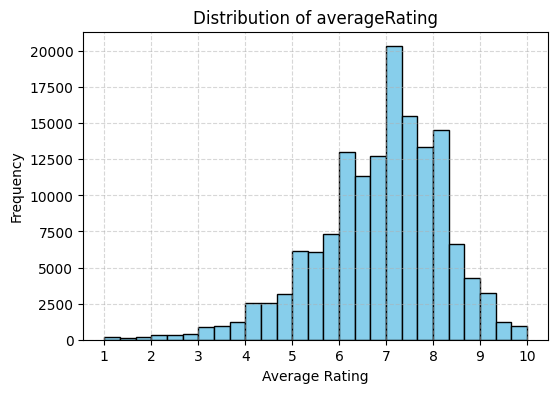

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(y, bins=27, color='skyblue', edgecolor='black')
# Add line plot for visualizing the continuous nature of ratings
# plt.plot(y_train, , 'x', alpha=0.5)
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.xticks(range(1,11))
# plt.yscale('log')
plt.title('Distribution of averageRating')
plt.grid(alpha=0.5, linestyle='--')
plt.show()

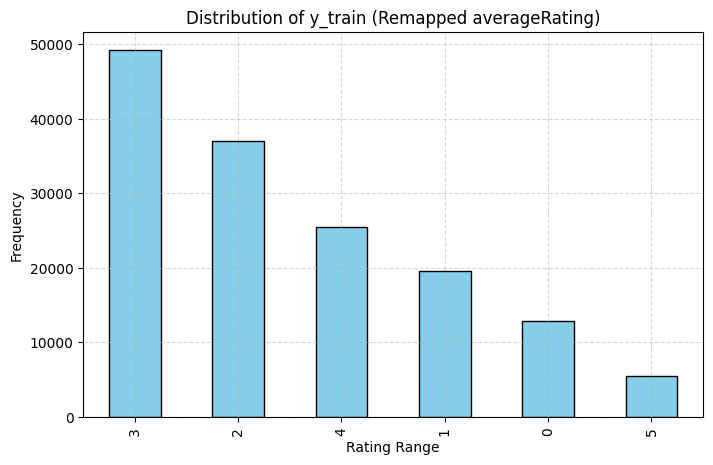

In [136]:
# Map values in intervals to new  bins
def remap_rating(rating):
    if rating < 5:
        return 0
    elif 5 <= rating < 6:
        return 1
    elif 6 <= rating < 7:
        return 2
    elif 7 <= rating < 8:
        return 3
    elif 8 <= rating < 9:
        return 4
    else:  # 9 <= rating <= 10
        return 5
    
# Remap y_train and y_test
y = y.map(remap_rating)

# Barplot the new distribution
plt.figure(figsize=(8, 5))
y.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Rating Range')
plt.ylabel('Frequency')
plt.title('Distribution of y_train (Remapped averageRating)')
# plt.xticks(rotation=45)
plt.grid(alpha=0.5, linestyle='--')
plt.show()

In [137]:
y = pd.get_dummies(y, prefix='rating', dtype=int)

In [138]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

In [139]:
import numpy as np


to_log = [
       'numRegions', 'ratingCount', 'companiesNumber',
       'totalNominations', 'totalMedia', 'totalReviews',
]

for col in to_log:
    X_train[col] = np.log1p(X_train[col].fillna(0).clip(lower=0))
    X_val[col] = np.log1p(X_val[col].fillna(0).clip(lower=0))
    X_test[col] = np.log1p(X_test[col].fillna(0).clip(lower=0))

In [140]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale])
X_val[to_scale] = scaler.transform(X_val[to_scale])
X_test[to_scale] = scaler.transform(X_test[to_scale])

In [141]:
# Counts for each class
y_train.value_counts().sort_index()

rating_0  rating_1  rating_2  rating_3  rating_4  rating_5
0         0         0         0         0         1            3293
                                        1         0           15248
                              1         0         0           29498
                    1         0         0         0           22219
          1         0         0         0         0           11746
1         0         0         0         0         0            7714
Name: count, dtype: int64

In [142]:
X_train = {
    'numerical': X_train[numerical_cols].values,
    'region': X_train[region_cols].values,
    'genre': X_train[genre_cols].values,
    'titletype': X_train[titletype_cols].values
}

X_val = {
    'numerical': X_val[numerical_cols].values,
    'region': X_val[region_cols].values,
    'genre': X_val[genre_cols].values,
    'titletype': X_val[titletype_cols].values
}

X_test = {
    'numerical': X_test[numerical_cols].values,
    'region': X_test[region_cols].values,
    'genre': X_test[genre_cols].values,
    'titletype': X_test[titletype_cols].values
}

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Numerical input
numerical_input = layers.Input(shape=(len(numerical_cols),), name='numerical')
numerical_branch = layers.Dense(96)(numerical_input)
numerical_branch = layers.BatchNormalization()(numerical_branch)
numerical_branch = layers.Activation('swish')(numerical_branch)
# numerical_branch = layers.LeakyReLU()(numerical_branch)

# Region input
region_input = layers.Input(shape=(len(region_cols),), name='region')
region_branch = layers.Dense(16, use_bias=False)(region_input)
region_branch = layers.BatchNormalization()(region_branch)
region_branch = layers.Activation('swish')(region_branch)
# region_branch = layers.LeakyReLU()(region_branch)

# Genre input
genre_input = layers.Input(shape=(len(genre_cols),), name='genre')
genre_branch = layers.Dense(8, use_bias=False)(genre_input)
genre_branch = layers.BatchNormalization()(genre_branch)
genre_branch = layers.Activation('swish')(genre_branch)
# genre_branch = layers.LeakyReLU()(genre_branch)

# Titletype input
titletype_input = layers.Input(shape=(len(titletype_cols),), name='titletype')
titletype_branch = layers.Embedding(
    input_dim=len(titletype_cols),
    output_dim=8,
    input_length=1
)(titletype_input)
titletype_branch = layers.Flatten()(titletype_branch)
titletype_branch = layers.Dense(8, use_bias=False)(titletype_branch)
titletype_branch = layers.BatchNormalization()(titletype_branch)
titletype_branch = layers.Activation('swish')(titletype_branch)

# Concatenate all branches
concatenated = layers.concatenate([numerical_input, region_branch, genre_branch, titletype_branch])

# Dropout on concatenated inputs
# x = layers.Dropout(0.2)(concatenated)

# 1st layer
x = layers.Dense(128, use_bias=False)(concatenated)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
# x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)

# 2nd layer
x = layers.Dense(128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
# x = layers.LeakyReLU()(x)
x = layers.Dropout(0.2)(x)

# 3rd layer
x = layers.Dense(64, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
x = layers.Dropout(0.3)(x)

# 4th layer
x = layers.Dense(32, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)
x = layers.Dropout(0.3)(x)

# Output layer
output = layers.Dense(y.shape[1],)(x)
output = layers.BatchNormalization()(output)
output = layers.Activation('sigmoid')(output)

model_rating = tf.keras.Model(
    inputs=[numerical_input, region_input, genre_input, titletype_input],
    outputs=output
)


model_rating.compile(
    optimizer=Adam(learning_rate=0.0006),
    loss='CategoricalCrossentropy',
    metrics=['accuracy']
)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [172]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(y_train.shape[1]),
    y=np.argmax(y_train.values, axis=1)
)
class_weights = {i: class_weights[i] for i in range(y_train.shape[1])}

history_rating = model_rating.fit(
    X_train, y_train,
    epochs=500, batch_size=64, validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True
        )
    ]
)

Epoch 1/500
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.2398 - loss: 1.6972 - val_accuracy: 0.2679 - val_loss: 1.6110
Epoch 2/500
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.2658 - loss: 1.5579 - val_accuracy: 0.2821 - val_loss: 1.5799
Epoch 3/500
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.2806 - loss: 1.5325 - val_accuracy: 0.3021 - val_loss: 1.5575
Epoch 4/500
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.2882 - loss: 1.5190 - val_accuracy: 0.3177 - val_loss: 1.5294
Epoch 5/500
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2890 - loss: 1.5175 - val_accuracy: 0.2975 - val_loss: 1.5474
Epoch 6/500
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2899 - loss: 1.5057 - val_accuracy: 0.3176 - val_loss: 1.5252
Epoch 7/500
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.2973 - loss: 1.4995 - val_accuracy: 0.3197 - val_loss: 1.5186
Epoch 8/500
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.3009 - loss:

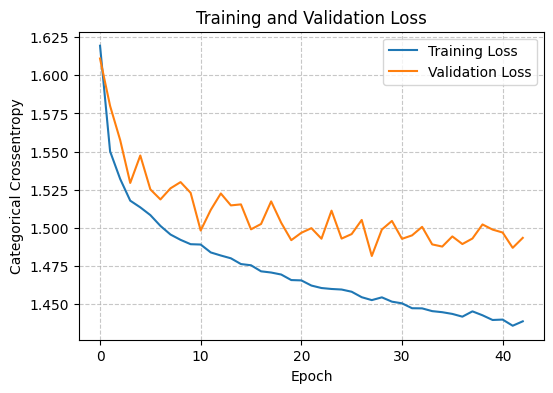

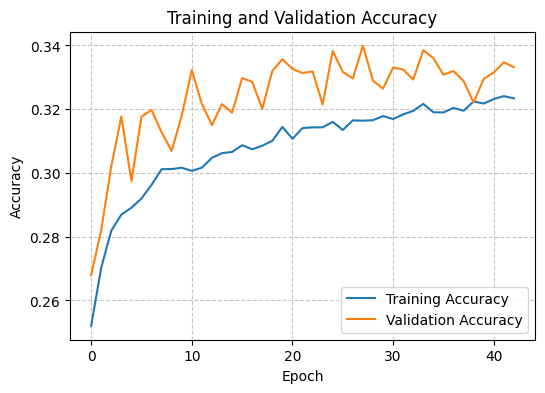

In [173]:
plt.figure(figsize=(6, 4))
plt.plot(history_rating.history['loss'], label='Training Loss')
plt.plot(history_rating.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Categorical Crossentropy')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history_rating.history['accuracy'], label='Training Accuracy')
plt.plot(history_rating.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(alpha=0.7, linestyle='--')
plt.show()

In [174]:
# Convert y_true_values to ndarray
y_true_classes = y_test.to_numpy()

935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
              precision    recall  f1-score   support

      [0, 5)       0.28      0.55      0.37      2571
      [5, 6)       0.30      0.32      0.31      3915
      [6, 7)       0.42      0.19      0.26      7407
      [7, 8)       0.52      0.41      0.46      9833
      [8, 9)       0.31      0.28      0.29      5083
     [9, 10)       0.13      0.59      0.21      1098

    accuracy                           0.34     29907
   macro avg       0.33      0.39      0.32     29907
weighted avg       0.40      0.34      0.34     29907



<Figure size 400x400 with 0 Axes>

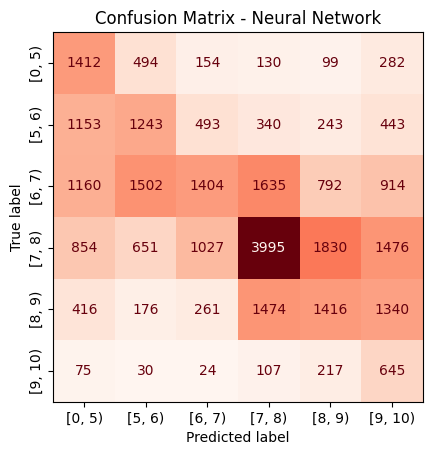

In [175]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np # Import numpy for argmax function

# Target names array is correctly ordered
target_names = [
    '[0, 5)',
    '[5, 6)',
    '[6, 7)',
    '[7, 8)',
    '[8, 9)',
    '[9, 10)'
]
                
# Predict on the test set
y_pred = model_rating.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_true_classes.argmax(axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

plt.figure(figsize=(4, 4))

# 1. Manually create the confusion matrix
# Use the corrected y_true_classes along with the predicted classes
cm = confusion_matrix(y_true_classes, y_pred_classes,)

# 2. Create a new ConfusionMatrixDisplay object with the original matrix and labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)


disp.xticks_rotation = 45

# 3. Plot the confusion matrix
disp.plot(cmap='Reds', colorbar=False)

plt.xticks(rotation=0)
plt.yticks(rotation=90, va='center')
plt.title('Confusion Matrix - Neural Network')
plt.show()

935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


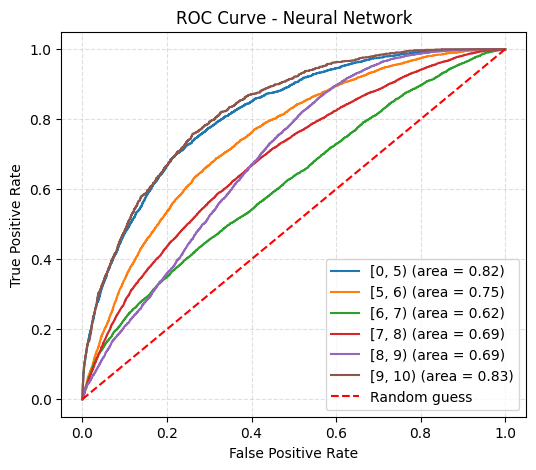

In [176]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for each rating bin
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_classes == i, model_rating.predict(X_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
for i in range(len(target_names)):
    plt.plot(fpr[i], tpr[i], label='{} (area = {:.2f})'.format(target_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.title('ROC Curve - Neural Network')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(linestyle='--', alpha=0.4)
plt.show()

In [177]:
# Save rating model
# model_rating.save('neural_net_rating_model.keras')